# Transfer Learning: A Comprehensive Guide

## 1. Introduction to Transfer Learning

Transfer learning is a machine learning technique where knowledge gained from solving one problem is applied to a different but related problem. In the context of deep learning, this typically involves taking a pre-trained neural network model and adapting it to a new task, often with much less data than would be required to train an equivalent model from scratch.

## 2. Why Transfer Learning is Essential

### 2.1 Limited Data Challenges
One of the most significant challenges in machine learning is the requirement for large quantities of labeled data. Transfer learning addresses this by leveraging knowledge from models trained on massive datasets (like ImageNet with 1.2 million images).

### 2.2 Computational Efficiency
Training deep neural networks from scratch requires substantial computational resources and time. Transfer learning dramatically reduces these requirements by reusing pre-trained weights for most of the network.

### 2.3 Performance Advantages
Even when sufficient data is available, transfer learning often leads to better performance, especially in the early stages of training. This occurs because the pre-trained networks have already learned useful feature representations.

### 2.4 Generalization Properties
Features learned from large, diverse datasets tend to generalize well to other tasks, particularly in the earlier layers of neural networks where more generic features are captured.

## 3. The Theory Behind Transfer Learning

### 3.1 Feature Hierarchy in Neural Networks
Neural networks, particularly convolutional neural networks (CNNs), learn hierarchical feature representations:
- Early layers learn simple, general features (edges, colors, textures)
- Middle layers learn more complex patterns and combinations of simpler features
- Later layers learn highly specific features relevant to the original task

This hierarchy enables transfer learning because the early and middle layers often learn representations useful across different tasks.

### 3.2 Transfer Learning Approaches

#### 3.2.1 Feature Extraction
In this approach, the pre-trained network acts as a fixed feature extractor. All layers except the final classification layer(s) are frozen, and only the new task-specific layers are trained.

#### 3.2.2 Fine-Tuning
This approach involves unfreezing some or all of the pre-trained layers and continuing training with a small learning rate. This allows the model to adapt more specifically to the new task.

### 3.3 When to Use Transfer Learning

Transfer learning is most effective when:
- The source and target tasks are related
- The pre-trained model was trained on a large, diverse dataset
- The target task has limited training data
- The target task would benefit from the feature representations learned by the source model

## 4. Implementing Transfer Learning in PyTorch

### 4.1 Step-by-Step Implementation

#### 4.1.1 Loading a Pre-trained Model
```python
import torch
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet model
model = models.resnet50(weights='IMAGENET1K_V2')

# View the model architecture
print(model)
```

#### 4.1.2 Feature Extraction Approach
```python
# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False
    
# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_target_classes)  # Replace with new layer
```

#### 4.1.3 Fine-Tuning Approach
```python
# Freeze early layers
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name:  # Only unfreeze layer4 and final layer
        param.requires_grad = False
        
# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_target_classes)
```

### 4.2 Complete Transfer Learning Implementation

```python
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Special case for inception because in training it has an auxiliary output
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return model and histories
    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }
    
    return model, history

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Example with a small dataset like flowers
data_dir = 'flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained model
model_ft = models.resnet50(weights='IMAGENET1K_V2')

# Method 1: Feature Extraction - Replace the final layer and only train that
for param in model_ft.parameters():
    param.requires_grad = False

# New final layer with random weights
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate
model_ft, hist_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=15)

# Visualize the results
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(hist_ft['train_acc'], label='Training Accuracy')
plt.plot(hist_ft['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(hist_ft['train_loss'], label='Training Loss')
plt.plot(hist_ft['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('transfer_learning_results.png')
plt.show()

# Method 2: Fine-Tuning - Unfreeze more layers for further training
model_ft_2 = models.resnet50(weights='IMAGENET1K_V2')

# Freeze all layers except the last two blocks and the final layer
ct = 0
for name, child in model_ft_2.named_children():
    ct += 1
    if ct < 7:  # Freeze early layers (adjust based on model architecture)
        for param in child.parameters():
            param.requires_grad = False

# Replace final layer
num_ftrs = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs, len(class_names))

model_ft_2 = model_ft_2.to(device)

# Different learning rates for different parts of the network
params_to_update = []
for name, param in model_ft_2.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

# Use a smaller learning rate for fine-tuning
optimizer_ft_2 = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

# Train and evaluate
model_ft_2, hist_ft_2 = train_model(model_ft_2, dataloaders, criterion, optimizer_ft_2, num_epochs=10)
```

## 5. Advanced Transfer Learning Strategies

### 5.1 Progressive Unfreezing
Instead of unfreezing all layers at once, progressively unfreeze layers starting from the top:

```python
def freeze_model_except_final_layer(model):
    """Freeze all layers except the final layer"""
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

def unfreeze_layer(model, layer_name):
    """Unfreeze a specific layer by name"""
    for name, child in model.named_children():
        if name == layer_name:
            for param in child.parameters():
                param.requires_grad = True
    return model

# Initial training with only the final layer
model = freeze_model_except_final_layer(model)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# Train for a few epochs...

# Unfreeze layer4 and continue training
model = unfreeze_layer(model, 'layer4')
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
# Train for more epochs...

# Unfreeze layer3 and continue training
model = unfreeze_layer(model, 'layer3')
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
# Continue training...
```

### 5.2 Discriminative Learning Rates
Apply different learning rates to different layers, with lower rates for early layers:

```python
from torch.optim import Adam

def get_layer_groups(model):
    """Group layers for applying different learning rates"""
    return [
        model.layer1,
        model.layer2,
        model.layer3,
        model.layer4,
        model.fc
    ]

layer_groups = get_layer_groups(model)
lr_mult = 0.1  # Learning rate multiplier between groups

# Create parameter groups with different learning rates
param_groups = []
for i, group in enumerate(layer_groups):
    param_groups.append({
        'params': group.parameters(),
        'lr': base_lr * (lr_mult ** (len(layer_groups) - i - 1))
    })

optimizer = Adam(param_groups)
```

## 6. Transfer Learning Patterns and Best Practices

### 6.1 Decision Framework for Transfer Learning

1. **Task Similarity Assessment**:
   - High similarity, small dataset → Feature extraction only
   - High similarity, large dataset → Fine-tuning (partial or full)
   - Low similarity, small dataset → Feature extraction with more custom layers
   - Low similarity, large dataset → Consider training from scratch or extensive fine-tuning

2. **Layer Freezing Strategy**:
   - For image classification tasks:
     - If target domain is similar to source domain, freeze early layers
     - If target domain is different, consider training more layers
   - For non-vision tasks, freezing strategies depend on domain overlap

3. **Learning Rate Selection**:
   - For frozen feature extraction: Use normal learning rates (0.001-0.01)
   - For fine-tuning: Use smaller learning rates (0.0001-0.001)
   - For discriminative learning rates: Use even smaller rates for early layers

### 6.2 Avoiding Common Pitfalls

1. **Catastrophic Forgetting**: When fine-tuning with high learning rates, the model may forget useful pre-trained features.
   - Solution: Use lower learning rates and proper regularization techniques

2. **Training/Validation Mismatch**: Using different transforms for training and validation can cause misleading results.
   - Solution: Ensure consistency in data preprocessing between phases

3. **Domain Shift**: When source and target datasets are too different.
   - Solution: Consider domain adaptation techniques or more extensive fine-tuning

## 7. Diagrams and Flowcharts

### 7.1 Transfer Learning Conceptual Framework
```
Pre-trained Model                New Model
+-------------------+           +-------------------+
| Input Layer       |           | Input Layer       |
| (Generic Features)|           | (Reused)          |
+-------------------+           +-------------------+
         |                               |
+-------------------+           +-------------------+
| Hidden Layers     |           | Hidden Layers     |
| (Task-Specific    |  ------>  | (Partially        |
|  Features)        |           |  Reused/Updated)  |
+-------------------+           +-------------------+
         |                               |
+-------------------+           +-------------------+
| Output Layer      |           | New Output Layer  |
| (Original Classes)|           | (Target Classes)  |
+-------------------+           +-------------------+
```

### 7.2 Decision Process for Transfer Learning Approach

```
              Start
                |
      +-------------------+
      | Evaluate Data Size|
      +-------------------+
               /\
              /  \
   Small     /    \    Large
            /      \
           v        v
+-------------------+  +-------------------+
| Feature Extraction|  | Consider Domain   |
| (Freeze Layers)   |  | Similarity        |
+-------------------+  +-------------------+
          |                     /\
          |                    /  \
          |        Similar    /    \   Different
          |                  /      \
          |                 v        v
          |    +-------------------+ +-------------------+
          |    | Fine-tuning       | | Extensive         |
          |    | (Unfreeze Top Few)| | Fine-tuning or    |
          |    |                   | | Train from Scratch|
          |    +-------------------+ +-------------------+
          |              |                    |
          v              v                    v
      +--------------------------------------+
      | Train and Evaluate on Target Task    |
      +--------------------------------------+
                        |
                        v
                     End
```

### 7.3 Layer Freezing Strategy Visualization

```
ResNet Architecture         Freezing Strategy         Parameters Status
                          
Input  ----------------->  +-------------------+      +-------------------+
                          | conv1              |      | Frozen            |
Layer1 ----------------->  +-------------------+      +-------------------+
                          | layer1             |      | Frozen            |
Layer2 ----------------->  +-------------------+      +-------------------+
                          | layer2             |      | Frozen            |
Layer3 ----------------->  +-------------------+      +-------------------+
                          | layer3             |      | Trainable         |
Layer4 ----------------->  +-------------------+      +-------------------+
                          | layer4             |      | Trainable         |
FC     ----------------->  +-------------------+      +-------------------+
                          | fc (replaced)      |      | Trainable         |
                          +-------------------+      +-------------------+
```

## 8. Case Studies and Performance Comparisons

### 8.1 Comparison of Transfer Learning Approaches

| Approach | Training Time | Validation Accuracy | Use Case |
|----------|---------------|---------------------|----------|
| Training from Scratch | 100% | Baseline | Large, unique datasets |
| Feature Extraction | 10-20% | +5-15% | Small datasets, similar domain |
| Partial Fine-tuning | 30-50% | +10-20% | Medium datasets, similar domain |
| Full Fine-tuning | 70-90% | +15-25% | Large datasets, different domain |

### 8.2 Typical Learning Curves

During transfer learning, validation accuracy often follows different patterns:
- Feature extraction: Rapid initial improvement, then plateaus
- Fine-tuning: Slower initial improvement, but higher final accuracy
- From scratch: Slow improvement throughout training

## 9. Practical Applications of Transfer Learning

### 9.1 Common Application Areas

1. **Image Classification**: Using models pre-trained on ImageNet to classify domain-specific images
2. **Object Detection**: Adapting classification models for localization tasks
3. **Semantic Segmentation**: Using encoder-decoder architectures with pre-trained encoders
4. **Natural Language Processing**: Using pre-trained word embeddings or language models
5. **Medical Imaging**: Adapting models trained on natural images to medical image analysis

### 9.2 Implementation Tips

1. **Data Preprocessing**:
   - Match your data preprocessing to that of the pre-trained model
   - For ImageNet-trained models, use normalization with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

2. **Batch Size Adjustment**:
   - Feature extraction: Can use larger batch sizes
   - Fine-tuning: May require smaller batch sizes to prevent overfitting

3. **Learning Rate Scheduling**:
   - Start with small learning rates
   - Use learning rate decay strategies like StepLR or ReduceLROnPlateau

4. **Regularization**:
   - Apply dropout in new layers
   - Use weight decay to prevent overfitting during fine-tuning

## Conclusion

Transfer learning has revolutionized the way we approach deep learning problems by enabling efficient knowledge reuse across tasks. By following the strategies and best practices outlined in this guide, you can effectively leverage pre-trained models to achieve better performance with less data and computational resources on your specific tasks.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('/content/fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [5]:
df.shape

(6000, 785)

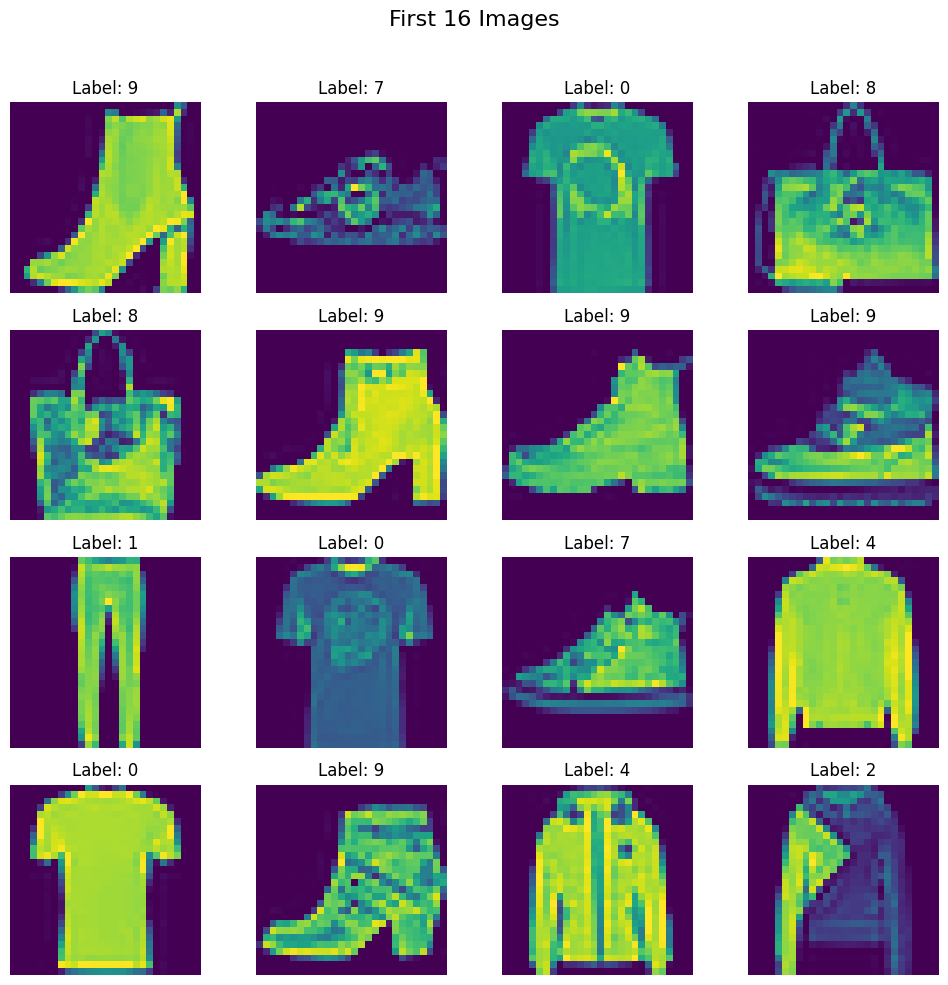

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [7]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# transformations
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # it converts PIL image to tensor and scale values between 0 to 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, features, labels, transform):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize to (28, 28)
    image = self.features[index].reshape(28,28)

    # change datatype to np.uint8
    image = image.astype(np.uint8)

    # change black&white to color -> (H,W,C) -> (C,H,W)
    image = np.stack([image]*3, axis=-1)

    # convert array to PIL image
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return
    return image, torch.tensor(self.labels[index], dtype=torch.long)

In [11]:
train_dataset = CustomDataset(X_train, y_train, transform=custom_transform)

In [12]:
test_dataset = CustomDataset(X_test, y_test, transform=custom_transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [14]:
# fetch the pretrained model

import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.3MB/s]


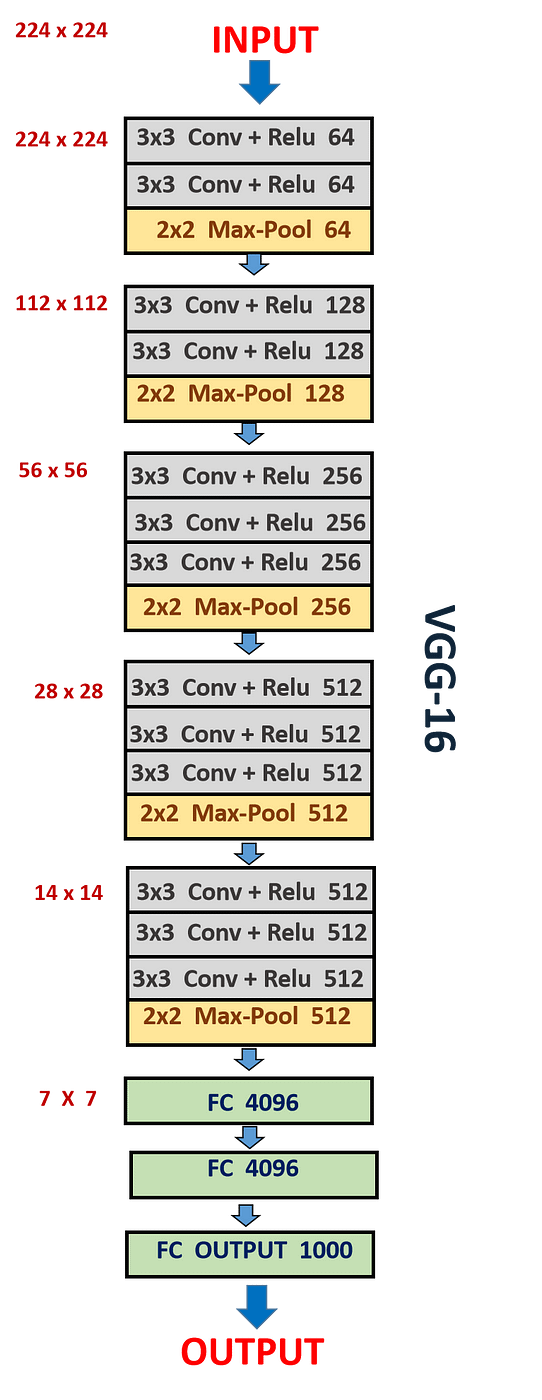

In [15]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
for param in vgg16.features.parameters():
  param.requires_grad=False

In [17]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

In [18]:
vgg16 = vgg16.to(device)

In [19]:
learning_rate = 0.001
epochs = 100

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

In [21]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = vgg16(batch_features)

    print(outputs.shape)
    print(batch_labels.shape)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

    break

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


torch.Size([32, 10])
torch.Size([32])
Epoch: 1 , Loss: 0.015262775421142578
torch.Size([32, 10])
torch.Size([32])
Epoch: 2 , Loss: 0.02026596705118815
torch.Size([32, 10])
torch.Size([32])
Epoch: 3 , Loss: 0.015172567367553711
torch.Size([32, 10])
torch.Size([32])
Epoch: 4 , Loss: 0.013055711587270102
torch.Size([32, 10])
torch.Size([32])
Epoch: 5 , Loss: 0.011294205983479818
torch.Size([32, 10])
torch.Size([32])
Epoch: 6 , Loss: 0.008434693018595377
torch.Size([32, 10])
torch.Size([32])
Epoch: 7 , Loss: 0.008670151233673096
torch.Size([32, 10])
torch.Size([32])
Epoch: 8 , Loss: 0.00874093214670817
torch.Size([32, 10])
torch.Size([32])
Epoch: 9 , Loss: 0.008592793941497803
torch.Size([32, 10])
torch.Size([32])
Epoch: 10 , Loss: 0.005086110432942708
torch.Size([32, 10])
torch.Size([32])
Epoch: 11 , Loss: 0.006647570133209229
torch.Size([32, 10])
torch.Size([32])
Epoch: 12 , Loss: 0.011768036683400472
torch.Size([32, 10])
torch.Size([32])
Epoch: 13 , Loss: 0.0092406431833903
torch.Size([

In [22]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8433333333333334


In [24]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8995833333333333


In [2]:
# import os
# import torchvision
# from torchvision.datasets import Flowers102
# from torch.utils.data import random_split
# from torchvision import transforms

# # Create directories
# os.makedirs('flower_data/train', exist_ok=True)
# os.makedirs('flower_data/val', exist_ok=True)

# # Define transformations
# transform = transforms.Compose([
#     transforms.ToTensor()
# ])

# # Download the dataset
# dataset = Flowers102(root='./data', download=True, transform=transform)

# # Split into train and validation sets (80-20 split)
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Now you have train_dataset and val_dataset which you can use with DataLoader

100%|██████████| 345M/345M [00:15<00:00, 23.0MB/s]
100%|██████████| 502/502 [00:00<00:00, 789kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 21.5MB/s]


Using device: cuda:0


100%|██████████| 345M/345M [00:14<00:00, 23.1MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.34MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 24.5MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training on 816 samples, validating on 204 samples
Number of classes: 102
Initializing feature extraction model...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


Training feature extraction model...
Epoch 1/15
----------
train Loss: 4.6288 Acc: 0.0123
val Loss: 4.6072 Acc: 0.0245

Epoch 2/15
----------
train Loss: 4.5803 Acc: 0.0417
val Loss: 4.5812 Acc: 0.0441

Epoch 3/15
----------
train Loss: 4.5233 Acc: 0.0882
val Loss: 4.5499 Acc: 0.0637

Epoch 4/15
----------
train Loss: 4.4700 Acc: 0.1618
val Loss: 4.5200 Acc: 0.1078

Epoch 5/15
----------
train Loss: 4.4141 Acc: 0.2353
val Loss: 4.4923 Acc: 0.1422

Epoch 6/15
----------
train Loss: 4.3601 Acc: 0.3051
val Loss: 4.4592 Acc: 0.1618

Epoch 7/15
----------
train Loss: 4.3014 Acc: 0.3873
val Loss: 4.4313 Acc: 0.1814

Epoch 8/15
----------
train Loss: 4.2576 Acc: 0.4387
val Loss: 4.4031 Acc: 0.2059

Epoch 9/15
----------
train Loss: 4.2049 Acc: 0.5061
val Loss: 4.3779 Acc: 0.2157

Epoch 10/15
----------
train Loss: 4.1519 Acc: 0.5233
val Loss: 4.3465 Acc: 0.2206

Epoch 11/15
----------
train Loss: 4.1017 Acc: 0.5748
val Loss: 4.3149 Acc: 0.2353

Epoch 12/15
----------
train Loss: 4.0523 Acc: 0

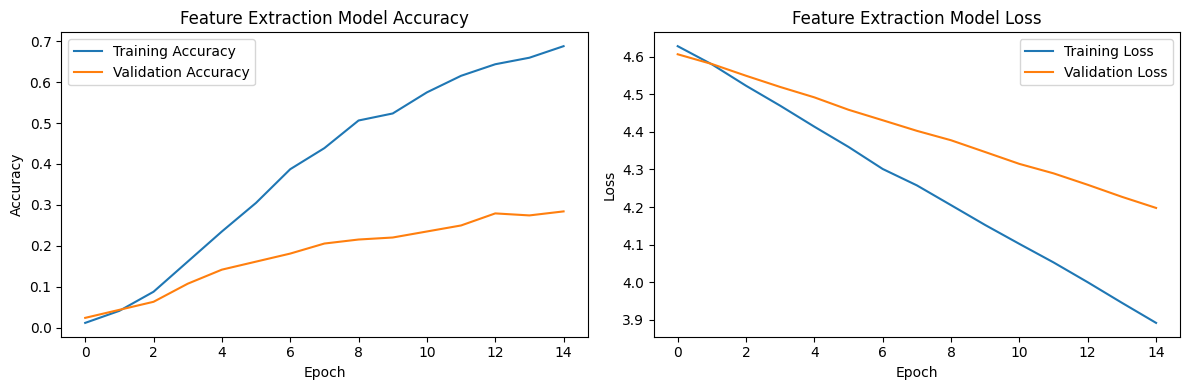

Initializing fine-tuning model...
Training 89 parameters in fine-tuning model
Training fine-tuning model...
Epoch 1/10
----------
train Loss: 4.6440 Acc: 0.0061
val Loss: 4.6361 Acc: 0.0098

Epoch 2/10
----------
train Loss: 4.6359 Acc: 0.0074
val Loss: 4.6310 Acc: 0.0147

Epoch 3/10
----------
train Loss: 4.6261 Acc: 0.0110
val Loss: 4.6284 Acc: 0.0147

Epoch 4/10
----------
train Loss: 4.6201 Acc: 0.0147
val Loss: 4.6246 Acc: 0.0196

Epoch 5/10
----------
train Loss: 4.6128 Acc: 0.0221
val Loss: 4.6213 Acc: 0.0147

Epoch 6/10
----------
train Loss: 4.6081 Acc: 0.0159
val Loss: 4.6190 Acc: 0.0147

Epoch 7/10
----------
train Loss: 4.6000 Acc: 0.0208
val Loss: 4.6154 Acc: 0.0196

Epoch 8/10
----------
train Loss: 4.5919 Acc: 0.0343
val Loss: 4.6127 Acc: 0.0196

Epoch 9/10
----------
train Loss: 4.5856 Acc: 0.0319
val Loss: 4.6082 Acc: 0.0196

Epoch 10/10
----------
train Loss: 4.5800 Acc: 0.0368
val Loss: 4.6043 Acc: 0.0245

Training complete in 1m 26s
Best val Acc: 0.0245
Fine-tuned m

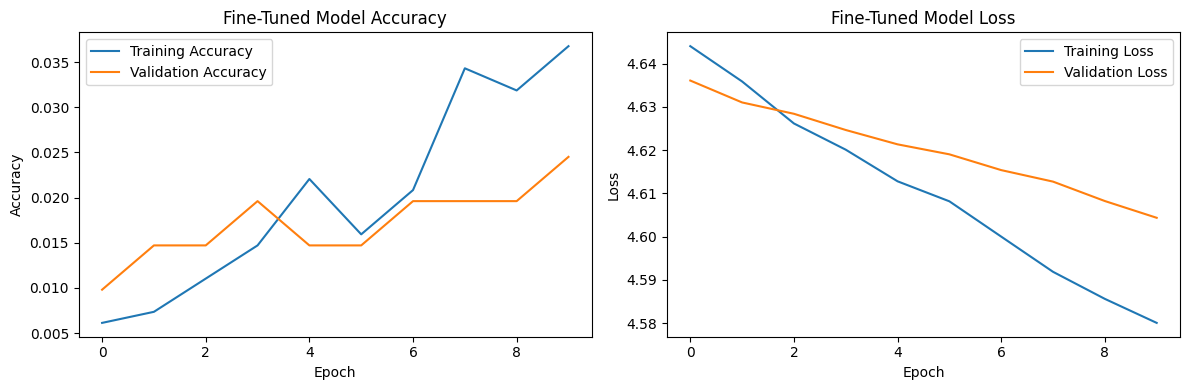

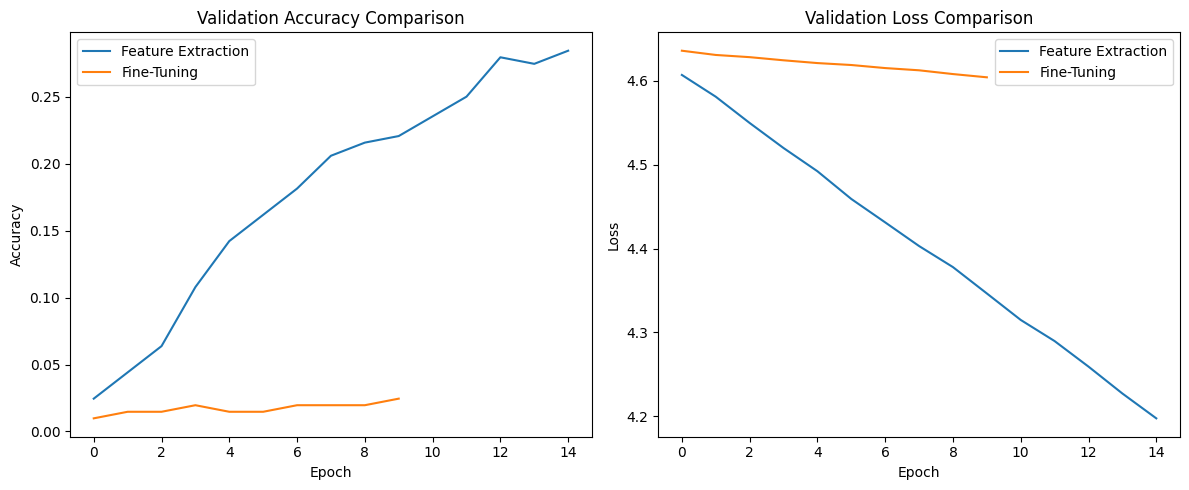

Transfer learning complete!


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import Flowers102
import time
import os
import copy
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Special case for inception because in training it has an auxiliary output
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Return model and histories
    history = {
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'train_acc': train_acc_history,
        'val_acc': val_acc_history
    }

    return model, history

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create data directory if it doesn't exist
os.makedirs('./data', exist_ok=True)

# Download and prepare the Flowers102 dataset
print("Downloading Flowers102 dataset...")
full_dataset = Flowers102(root='./data', download=True)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply transformations to the datasets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}

# Store dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Number of classes in Flowers102 is 102
num_classes = 102
print(f"Training on {dataset_sizes['train']} samples, validating on {dataset_sizes['val']} samples")
print(f"Number of classes: {num_classes}")

# Method 1: Feature Extraction - Load pre-trained model
print("Initializing feature extraction model...")
model_ft = models.resnet50(weights='IMAGENET1K_V2')

# Freeze all parameters
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the final layer with a new one
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# Move model to the specified device
model_ft = model_ft.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# We only optimize parameters of the final layer
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate the model with feature extraction
print("Training feature extraction model...")
model_ft, hist_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=15)

# Save the model
torch.save(model_ft.state_dict(), 'flower_resnet50_feature_extraction.pth')
print("Feature extraction model saved.")

# Visualize the results
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(hist_ft['train_acc'], label='Training Accuracy')
plt.plot(hist_ft['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Feature Extraction Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(hist_ft['train_loss'], label='Training Loss')
plt.plot(hist_ft['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Feature Extraction Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('feature_extraction_results.png')
plt.show()

# Method 2: Fine-Tuning
print("Initializing fine-tuning model...")
model_ft_2 = models.resnet50(weights='IMAGENET1K_V2')

# Freeze all layers except the last two blocks and the final layer
ct = 0
for name, child in model_ft_2.named_children():
    ct += 1
    if ct < 7:  # Freeze early layers
        for param in child.parameters():
            param.requires_grad = False

# Replace final layer
num_ftrs = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs, num_classes)

model_ft_2 = model_ft_2.to(device)

# Collect parameters to update
params_to_update = []
for name, param in model_ft_2.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

print(f"Training {len(params_to_update)} parameters in fine-tuning model")

# Use a smaller learning rate for fine-tuning
optimizer_ft_2 = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

# Train and evaluate with fine-tuning
print("Training fine-tuning model...")
model_ft_2, hist_ft_2 = train_model(model_ft_2, dataloaders, criterion, optimizer_ft_2, num_epochs=10)

# Save the fine-tuned model
torch.save(model_ft_2.state_dict(), 'flower_resnet50_fine_tuned.pth')
print("Fine-tuned model saved.")

# Visualize the fine-tuning results
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(hist_ft_2['train_acc'], label='Training Accuracy')
plt.plot(hist_ft_2['val_acc'], label='Validation Accuracy')
plt.legend()
plt.title('Fine-Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(hist_ft_2['train_loss'], label='Training Loss')
plt.plot(hist_ft_2['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Fine-Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('fine_tuning_results.png')
plt.show()

# Compare the two approaches
plt.figure(figsize=(12, 5))

# Compare validation accuracy
plt.subplot(1, 2, 1)
plt.plot(hist_ft['val_acc'], label='Feature Extraction')
plt.plot(hist_ft_2['val_acc'], label='Fine-Tuning')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Compare validation loss
plt.subplot(1, 2, 2)
plt.plot(hist_ft['val_loss'], label='Feature Extraction')
plt.plot(hist_ft_2['val_loss'], label='Fine-Tuning')
plt.legend()
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('comparison_results.png')
plt.show()

# Function to test models on new images
def test_model(model, image_path):
    model.eval()

    # Load and preprocess the image
    img = Image.open(image_path)
    img_tensor = data_transforms['val'](img).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)

    return preds.item()

print("Transfer learning complete!")

### run it for more epochs to getter more better results